# Concept Bottleneck Models

In the "[The tale of the deep learning model that failed my driving exam](chapter01_teaser.ipynb)", we compared the decisions of an 18-year-old driver and a deep learning (DL) model when facing a tricky intersection where the driver had a green light, but an ambulance unexpectedly crossed. While both drivers stopped at the intersection, the teenager could explain how she arrived at that conclusion in terms of ***concepts*** like the light color and the presence (or absence) of the ambulance:
>  "I would have crossed if the ambulance wasn't there, but I know for sure that I would never cross in the presence of an ambulance." [Example of a human driver explanation]

In contrast, the DL model, despite making the correct decision and having been trained on millions of instances where lights and ambulances were around, lacked a satisfying decision-making process for the driving evaluator, as the model's explanations were based on raw pixel activations:
>  "If pixel 2890 had an RGB value of (28, 178, 111), the model would have chosen to cross." [Example of a DL driver explanation]

This example highlights the need for developing DL models with a transparent decision-making process like the teenager's, especially in high-stakes fields such as medicine (deciding whether to give a certain treatment), finance (deciding whether to approve a loan), and law (checking whether a hiring system is fair).

## Blueprint for concept-based deep learning models

> ⚠️ **Warning:** The following paragraphs assume a basic understanding of probability.

From a technical standpoint, the problem can be described as follows: we aim to model a relationship between a set of random variables $X \in \mathcal{X}$ representing low-level perceptive features (such as pixels) and a set of random variables corresponding to decisions $Y \in \mathcal{Y}$ (whether to cross or stop).

The DL model in the tale modeled the relationship as $p(Y = \texttt{cross} \mid X = \texttt{image’s pixels})$, directly mapping raw image data to a decision.

```{figure} ../images/dnn.png
---
width: 50%
align: center
name: directive-fig
---
A DL model directly maps raw image features (pixels) to a decision (e.g., whether to cross). Image created by the author with assistance from GPT4-o.
```

The teenager, instead, modeled the same problem using intermediate **higher-level variables — referred to as “concepts”, like the light color and the ambulance — leading to a more human-interpretable decision-making process**. Based on such concepts, her reasoning could be expressed as $p(Y = \texttt{cross} \mid C_1 = \texttt{light color}, C_2 = \texttt{ambulance})$, where the concepts $C \in \mathcal{C}$ provided insight into **how** she made a particular decision.

```{figure} ../images/cym.png
---
width: 50%
align: center
name: directive-fig
---
A human driver bases their decisions (e.g., whether to cross) on concepts (e.g., ambulance crossing). Image created by the author.
```

To emulate the teenager's approach, we re-write the probability distribution $p(Y \mid X)$ as if it was obtained by marginalizing the joint distribution $p(Y,C \mid X)$ over the concepts $C$. Now, assuming that $Y$ is conditionally independent of $X$ given $C$ we can obtain the following factorization:

$$p(Y \mid X) = \sum_C p(Y, C \mid X) = \sum_C p(Y \mid C) \cdot p(C \mid X)$$

```{figure} ../images/cbm.png
---
width: 50%
align: center
name: directive-fig
---
A concept bottleneck model maps raw image features (pixels) to human-understandable concepts (e.g., ambulance crossing) and then relies on these predicted concepts to make decisions (e.g., whether to cross). Image created by the author with assistance from GPT4-o.
```

In this formulation, the model observes the input features $X$ (such as pixels from an image) and maps them to a set of interpretable, high-level variables $C$, known as "[***concepts***](https://arxiv.org/abs/1711.11279)" {cite:p}`bau2017network,kim2018interpretability,fong2018net2vec`. These concepts are analogous to the reasoning elements identified by the teenager — such as the traffic light color or the presence of an ambulance. The second part of the model then uses these concepts to determine the decision $Y$ (whether to cross or stop). This class of models is known as a [**Concept Bottleneck Model**](https://arxiv.org/abs/2007.04612) (CBM) {cite:p}`koh2020concept`. CBMs parameterize the conditional distributions with a pair of neural networks:
- A "*concept encoder*" $g(\cdot)$  that takes as an input a sample $\mathbf{x} \in \mathcal{X}$, and predicts a set of $k$ concepts $\mathbf{c} \in \mathcal{C}$. This network parameterizes the concept distribution.
- A "*task predictor*" $f(\cdot)$ that takes as an input a concept vector $\mathbf{c} \in \mathcal{C}$ and predicts an output label $y \in \mathcal{Y}$. This network parameterizes the output distribution.


Given a concept-based dataset of i.i.d. triples (input, concepts, task) $D = \{(\mathbf{x}, \mathbf{c}, y)\}$, the CBM’s parameters ($\theta_g$ and $\theta_f$) are usually optimized via gradient descent by maximizing the empirical log-likelihood of the training data:

\begin{align*}
    (\theta_g, \theta_f) &= \underset{\theta_g, \theta_f}{\operatorname{arg max}} \mathcal{L}\big(\theta_g, \theta_f, D \big) \\ &= \underset{\theta_g, \theta_f}{\operatorname{arg max}} \sum_{(\mathbf{x}, \mathbf{c}, y) \in D} \log p\big(Y = \mathbf{y}, C=\mathbf{c} \mid X=\mathbf{x} \; ; \; \theta_g, \theta_f \big) \\ &= \underset{\theta_g, \theta_f}{\operatorname{arg max}} \sum_{(\mathbf{x}, \mathbf{c}, y) \in D} \log p\big(Y = \mathbf{y} \mid C=\mathbf{c} \; ; \; \theta_f \big) + \log p\big(C=\mathbf{c} \mid X=\mathbf{x} \; ; \; \theta_g \big)
\end{align*}

In most instances (but not all), we are trying to model a scenario where we are given $k$ different concept annotations during training and the output task can be one of $L$ different labels (e.g., multi-task classification).
In this case, it is common to model the data distribution by interpreting the output of $g$ and $f$ as probabilities over their output domains.
That is
1. The concept encoder $g(x) = \hat{\mathbf{c}} \in [0, 1]^k$ outputs a $k$-dimensional vector where $\hat{\mathbf{c}}_i = p(\mathbf{c}_i = 1 \mid X = \mathbf{x})$, and
2. The label predictor $f(\mathbf{c}) = \hat{y} \in [0, 1]^L$ outputs a $L$-dimensional vector where $L$ is the number of output labels, $\sum_i \hat{\mathbf{y}}_i = 1$ (e.g., a softmax activation is used), and $\hat{\mathbf{y}}_i = p(Y = i \mid C = \mathbf{c})$.

In this instance, the likelihood above can be expressed as:

\begin{align*}
    (\theta_g, \theta_f) &= \underset{\theta_g, \theta_f}{\operatorname{arg max}} \sum_{(\mathbf{x}, \mathbf{c}, y) \in D} \Bigg( \log f\big(g(\mathbf{x} \; ; \; \theta_g) \; ; \; \theta_f \big)_y + \sum_{i = 1}^k \Big( \mathbf{c}_i \log g(\mathbf{x} \; ; \; \theta_g) + (1 - \mathbf{c}_i) \log \big(1 - g(\mathbf{x} \; ; \; \theta_g)\big) \Big) \Bigg) \\
    &= \underset{\theta_g, \theta_f}{\operatorname{arg min}} \sum_{(\mathbf{x}, \mathbf{c}, y) \in D}  \Bigg( \mathcal{L}_\text{CE}\big(y, f\big(g(\mathbf{x} \; ; \; \theta_g) \; ; \; \theta_f \big)\big) + \mathcal{L}_\text{BCE}\big(\mathbf{c}, g(\mathbf{x} \; ; \; \theta_g)\big) \Bigg)
    
\end{align*}

Where $\mathcal{L}_\text{CE}$ and $\mathcal{L}_\text{BCE}$ stand for the standard [cross entropy and binary cross entropy losses](https://en.wikipedia.org/wiki/Cross-entropy) (notice the $\operatorname{arg max}$ turned into an $\operatorname{arg min}$ as we are working with negative log-likelihoods when using the cross entropy losses).

In CBMs there are three different ways to optimize this objective function:
1. **Independent training** optimizes $f$ and $g$ independently: $f$ is trained using ground truth concepts $c$ as input. At test time, $f$ takes $g(x)$ as input.
2. **Sequential training** first optimizes $g$ independently. Once trained, the parameters of the concept encoder $g$ are frozen, and $f$ is trained using $g(x)$ as input.
3. **Joint training**: optimizes $f$ and $g$ at the same time and $f$ takes as input $g(x)$.

The following coding practice introduces you to implementing CBMs and shows how to query CBMs to understand the model's decision-making process.


## Coding practice

In this practice, we implement a Concept Bottleneck Model (CBM) for a simple traffic light scenario where decisions to cross or stop depend on two concepts: the traffic light being green and the presence of an ambulance. The model predicts these concepts and uses them to make decisions.

> ⚠️ **Warning:** This section assumes a basic understanding of programming machine learning scripts using deep learning frameworks, specifically PyTorch. If you're new to PyTorch, consider starting with [these introductory tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html) to get up to speed.


### Step #1: Install PyC

First, we install the necessary Python packages required to implement CBMs. This includes our [`pytorch-concepts`](https://github.com/pyc-team/pytorch_concepts) library, which runs on top of standard deep learning libraries ([`PyTorch`](https://pytorch.org/)).

In [1]:
%%capture
!pip install torch
!pip install https://github.com/pyc-team/pytorch_concepts/releases/download/v0.0.10/pytorch_concepts-0.0.10.tar.gz

### Step #2: Load traffic scenario

Next, we load the dataset for our traffic light scenario. This toy synthetic dataset, programatically generated in the call below, comprises a collection of images of a single intersection under different conditions. Each image is an image of an intersection where the "target" or "selected" car (the car we need
to make the decision for) is approaching the intersection from the left (moving in a west-to-east direction).
The task is to decide whether this car should `stop` (label is 0) or `continue` (task label is 1).

To help with learning concept-based models, this dataset's images are annotated with the
following concept labels:
*   **Green Light on Selected Lane**: Indicates whether the traffic light on the lane of the selected car is green or not.
*   **Car in Intersection**: Specifies whether another car is visible in the intersection.
*   **Ambulance Seen**: Specifies whether an ambulance is visible in the scene.
*   **Ambulance Approaching Perpendicular to Selected Car**: Specifies whether an ambulance is approaching in a north-to-south or south-to-north direction (i.e., it is moving perpendicularly w.r.t. the target car).

In [2]:
# Making seeds fixed for determinism

import numpy as np
import torch

seed = 42
print(f"Setting random seeds to {seed}")
torch.manual_seed(seed)
np.random.seed(seed)

Setting random seeds to 42


In [3]:
from torch_concepts.data import TrafficLights

# In practice, we need datasets that are significantly larger, but we will
# not use those for this example as we want to focus on the main ideas rather
# than on performane
n_samples = 500

# Loading dataset
dataset = TrafficLights(
    n_samples=n_samples,
    possible_starting_directions=['west'],
    resize_final_image=0.05,
    selected_concepts=[
        'green light on selected lane',
        'car in intersection',
        'ambulance seen',
        'ambulance approaching perpendicular to selected car',
    ],
    split='train',
)
concept_names, task_names = dataset.concept_names, dataset.task_names
n_concepts = len(concept_names)

# Example of scenario
print(f"Input shape: {dataset.input_shape}")
print(f"Using {n_concepts} concepts with semantics: {concept_names}")
print(f"Task has {len(task_names)} downstream tasks: {task_names}")

Input shape: (3, 64, 64)
Using 4 concepts with semantics: ['green light on selected lane', 'car in intersection', 'ambulance seen', 'ambulance approaching perpendicular to selected car']
Task has 1 downstream tasks: ['continue']


We can see some of examples of this dataset to get a sense as to how they look:

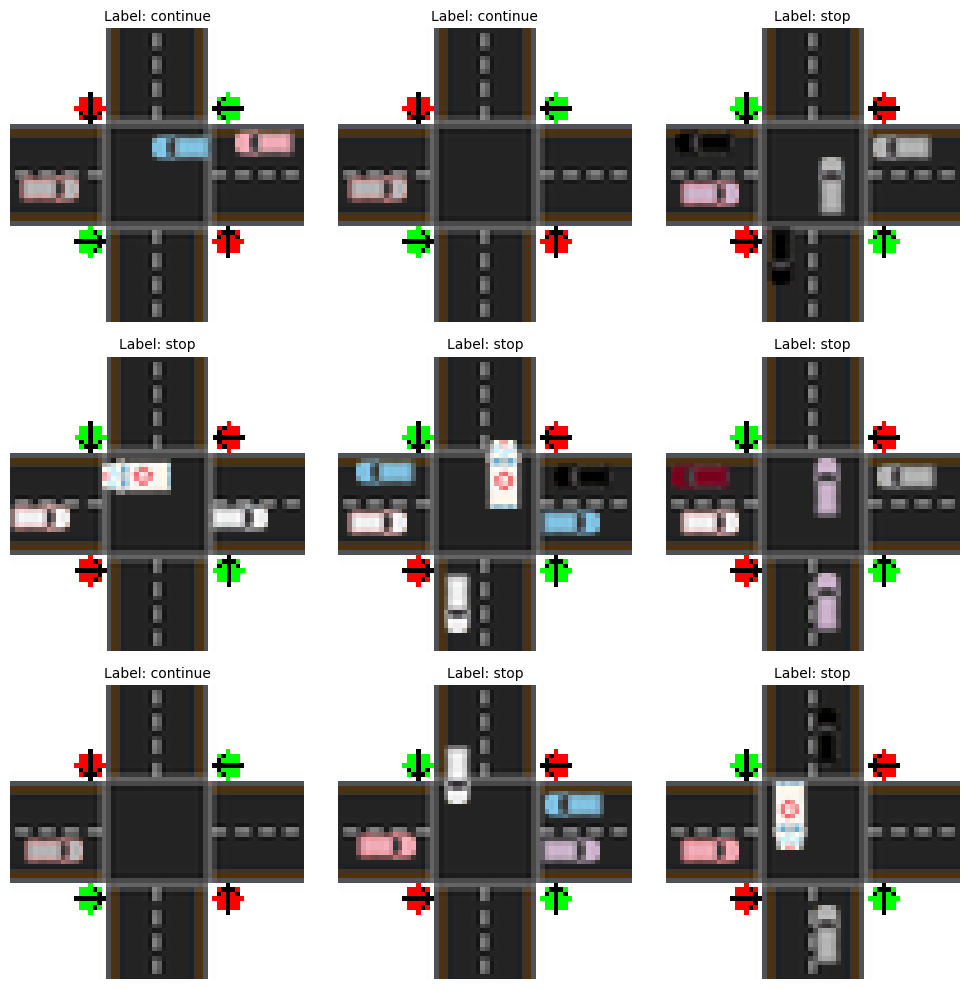

In [4]:
import matplotlib.pyplot as plt
import random

# Select a random sample of indices for the grid
grid_size = (3, 3)
indices = random.sample(range(len(dataset)), grid_size[0] * grid_size[1])
sampled_images = [dataset[i][0] for i in indices]
sampled_labels = [dataset[i][1] for i in indices]
label_names = ['stop', 'continue']

# Plot images in a grid
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
axes = axes.flatten()  # Flatten to easily iterate over axes if needed

for i, ax in enumerate(axes):
    ax.imshow(
        sampled_images[i].detach().cpu().numpy().transpose(1, 2, 0),
        cmap=None,
    )
    ax.set_title(
        f"Label: {label_names[int(sampled_labels[i])]}",
        fontsize=10,
    )
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

### Step #3: Define the CBM

We are now ready to construct our first CBM. The model comprises three main components: encoder, concept predictor, and task predictor.
These components are combined sequentially to form the complete CBM architecture.

**Encoder**: The encoder takes as input low-level features $X$ and produces a lower-dimensional representation. The specific architecture of the encoder depends on the input data type; it could be a convolutional neural network, a recurrent neural network, a transformer, or another suitable model.


Given that we will be working with images, we will use a very simple **Convolutional Neural Network (CNN)**:

In [5]:
import torch

latent_dims = 32

# The encoder extracts a low-dimensional representation of the input
encoder = torch.nn.Sequential(
    # A 3x3 convolution with 4 output channels
    torch.nn.Conv2d(3, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),

    # A 3x3 convolution with 4 output channels with a batch norm
    torch.nn.Conv2d(4, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm2d(4),

    # A 3x3 convolution with 4 output channels
    torch.nn.Conv2d(4, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),

    # A 3x3 convolution with 4 output channels with a batch norm
    torch.nn.Conv2d(4, 4, (3, 3), padding='same'),
    torch.nn.LeakyReLU(),
    torch.nn.BatchNorm2d(4),

    # A 5x5 max pooling layer
    torch.nn.MaxPool2d((5, 5)),

    # Finally, we flatten and map it to a known latent space size
    torch.nn.Flatten(start_dim=1, end_dim=-1),
    torch.nn.Linear(576, latent_dims),  # 576 comes from the size after flattening
    torch.nn.LeakyReLU(),
)
encoder

Sequential(
  (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): LeakyReLU(negative_slope=0.01)
  (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (8): LeakyReLU(negative_slope=0.01)
  (9): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=576, out_features=32, bias=True)
  (13): LeakyReLU(negative_slope=0.01)
)

**Linear Concept Layer**: A linear concept layer takes an embedding as input and generates a set of concept representations, which in this case correspond to concept logits. To implement concept layers, we use the [`PyC`](https://github.com/pyc-team/pytorch_concepts) library.

To define this layer, the following inputs are required:
- `in_features`: The size of the embedding generated by the encoder.
- `annotations`: A list of integers or list where each entry represents an axis of the output concept tensor, and, if it isa list, each element in that list represent the semantics assigned to the neuron at that corresponding index for that dimension.

For example, we can make a `LinearConceptLayer` that takes as an input a latent representation of size `8` and outputs two neurons aligned to concepts `["ambulance", "green light"]` through the following calls:

```python
c_layer_annotated = LinearConceptLayer(
    in_features=2,
    out_annotations=["ambulance", "green light"], # If we wish to annotate the output neurons with known concepts
)
```
Or:

```python
c_layer_unannotated = LinearConceptLayer(
    in_features=2,
    out_annotations=2, # If we do not wish to annotate the output neurons
)
```

<br>

In our example, this layer produces two concept logits corresponding to "traffic light green" and "ambulance crossing".

In [6]:
from torch_concepts.nn import LinearConceptLayer

# The concept scorer predicts concept logits {traffic light color, ambulance presence}
c_layer = LinearConceptLayer(
    in_features=latent_dims,
    out_annotations=concept_names,
)
print('Architecture:\n', c_layer)
print('Expected concepts in output tensor:\n', c_layer.annotations)

Architecture:
 LinearConceptLayer(
  (transform): Sequential(
    (0): Linear(in_features=32, out_features=4, bias=True)
    (1): Unflatten(dim=-1, unflattened_size=[4])
    (2): Annotate()
  )
)
Expected concepts in output tensor:
 [['green light on selected lane', 'car in intersection', 'ambulance seen', 'ambulance approaching perpendicular to selected car']]


In `PyC` concept layers produce as output an object of type `AnnotatedTensor` whose dimensions are labeled with the provided concept names:

In [7]:
concept_tensor = c_layer(torch.randn(1, latent_dims))
print(concept_tensor)

AnnotatedTensor of shape torch.Size([1, 4]), dtype torch.float32, and annotations [None, ['green light on selected lane', 'car in intersection', 'ambulance seen', 'ambulance approaching perpendicular to selected car']] for each dimension.


The object `AnnotatedTensor` has built-in methods to extract concept representations from specific dimensions which might be practical for in-depth analysis:

In [8]:
concept_traffic_light = concept_tensor.extract_by_annotations(['green light on selected lane'])
print(concept_traffic_light)

AnnotatedTensor of shape torch.Size([1, 1]), dtype torch.float32, and annotations [None, ['green light on selected lane']] for each dimension.


**Task Predictor**: Takes as input the predicted concept representations to determine the final decision on whether to cross or not. In this case, we implement the task predictor with a multi-layer perceptron, but we will discuss more advanced (and interpretable) task predictors later on in this series.


In [9]:
# The task predictor determines the value of the downstream label {cross}
y_predictor = torch.nn.Sequential(
    torch.nn.Linear(n_concepts, latent_dims),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(latent_dims, 1), # output shape 1 as it is a binary task
)
y_predictor

Sequential(
  (0): Linear(in_features=4, out_features=32, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=32, out_features=1, bias=True)
)

### Step #4: Train the CBM

We set the training parameters, including the number of epochs (`n_epochs`), the batch size (`batch_size`) and learning rate (`lr`). Using the AdamW optimizer and Binary Cross-Entropy Loss, we train the CBM through a standard PyTorch loop. Here we will train the model using its **joint** training, where the concept encoder and the label predictor are trained in an end-to-end manner.

Specifically, in each epoch the model performs a forward pass to predict concepts and the final decision, computes the combined loss, performs backpropagation, and updates the model parameters. The concept regularization weight (`concept_loss_weight`) controls the weight of the concept loss w.r.t. the downstream task loss:

In [10]:
from torch.utils.data import DataLoader

n_epochs = 20
concept_loss_weight = 10
lr = 0.01
batch_size = 50

# Define optimizer and loss function
model = torch.nn.Sequential(encoder, c_layer, y_predictor)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_fn = torch.nn.BCELoss()

# Make a batch dataset loader
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

# Standard PyTorch learning cycle
model.train()
for epoch in range(n_epochs):
    for batch_idx, (x, y, c, _, _) in enumerate(dataloader):
        # Encode input, then predict concept and downstream tasks activations
        emb = encoder(x)
        c_pred = c_layer(emb).sigmoid()
        y_pred = y_predictor(c_pred).sigmoid().view(-1)

        # Double loss on concepts and tasks
        loss = loss_fn(y_pred, y) + concept_loss_weight * loss_fn(c_pred, c)

        # Perform the update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        task_acc = torch.mean(((y_pred > 0.5) == y).type(torch.float))
        task_acc = task_acc.detach().cpu().numpy()
        if ((epoch + 1) % 5 == 0) and (batch_idx == 0):
            print(
                f"Epoch [{epoch+1}/{n_epochs}], "
                f"Step [{batch_idx+1}/{len(dataloader)}], "
                f"Loss: {loss.item():.4f}, "
                f"Task Accuracy: {task_acc * 100:.2f}%, "
            )

Epoch [5/20], Step [1/6], Loss: 3.3699, Task Accuracy: 82.00%, 
Epoch [10/20], Step [1/6], Loss: 1.8929, Task Accuracy: 96.00%, 
Epoch [15/20], Step [1/6], Loss: 1.2713, Task Accuracy: 94.00%, 
Epoch [20/20], Step [1/6], Loss: 0.6090, Task Accuracy: 100.00%, 


### Step #5: Trace task prediction back to concept activations

We can examine how the concept activations (green light and ambulance presence) influence the downstream task prediction.

For example, let's look at a sample where there is a green light for the car,
there are no ambulances, and no cars in the intersection. For this, we will
first find an example in the training set that has all these properties:

In [11]:
# Load the data to memory for easy use (we would not recommend doing this for
# large datasets!):
x_samples = []
c_samples = []
y_samples = []
for (x, y, c, _, _) in dataset:
    x_samples.append(x.unsqueeze(0))
    y_samples.append(y.unsqueeze(0))
    c_samples.append(c.unsqueeze(0))
x_samples = torch.concat(x_samples, dim=0)
y_samples = torch.concat(y_samples, dim=0)
c_samples = torch.concat(c_samples, dim=0)

In [12]:
import numpy as np

# Find all training examples where the light is green, there is no ambulance,
# and there are no cars in the intersection:
samples_with_green_light = (c_samples[:, 0] == 1).detach().cpu().numpy()
samples_with_int_cars = (c_samples[:, 1] == 1).detach().cpu().numpy()
samples_with_ambulance = (c_samples[:, 2] == 1).detach().cpu().numpy()
samples_with_perp_ambulance = (c_samples[:, 3] == 1).detach().cpu().numpy()
selected_samples = (
    samples_with_green_light &
    np.logical_not(samples_with_int_cars) &
    np.logical_not(samples_with_ambulance) &
    np.logical_not(samples_with_perp_ambulance)
)
print(
    "Found",
    np.sum(selected_samples),
    "samples with green light, no ambulance, and no cars on the intersection"
)

Found 82 samples with green light, no ambulance, and no cars on the intersection


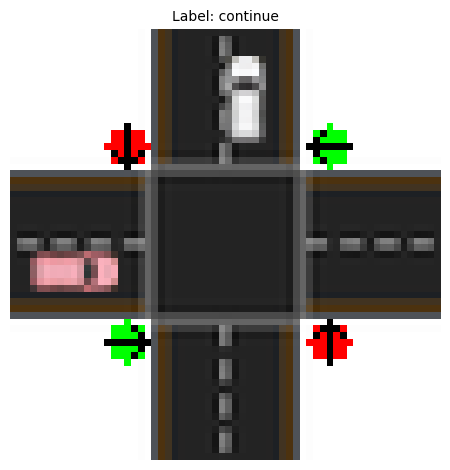

In [13]:
import matplotlib.pyplot as plt

# Select one of those examples for visualization:
selected_sample = x_samples[selected_samples, :, :, :][0]
selected_label = y_samples[selected_samples][0]
label_names = ['stop', 'continue']

# And visualize it
plt.imshow(
    selected_sample.detach().cpu().numpy().transpose(1, 2, 0),
    cmap=None,
)
plt.title(
    f"Label: {label_names[int(selected_label)]}",
    fontsize=10,
)
plt.axis('off')

plt.tight_layout()
plt.show()

Now, let's look at our model's predictions for this sample:

In [14]:
model.eval()
emb = encoder(selected_sample.unsqueeze(0))
c_pred = c_layer(emb).sigmoid()
y_pred = y_predictor(c_pred).sigmoid().view(-1)
print(f"Task Prediction: {label_names[(y_pred[0]>0.5)]}")
for idx, concept_name in enumerate(concept_names):
    pred_str = "ON" if c_pred[0, idx] > 0.5 else "OFF"
    print(
        f"\tOur model predicted concept '{concept_name}' to be {pred_str} "
        f"(with prob {c_pred[0, idx]})"
    )

Task Prediction: continue
	Our model predicted concept 'green light on selected lane' to be ON (with prob 0.9999604225158691)
	Our model predicted concept 'car in intersection' to be OFF (with prob 0.01809137873351574)
	Our model predicted concept 'ambulance seen' to be OFF (with prob 3.915355136996368e-06)
	Our model predicted concept 'ambulance approaching perpendicular to selected car' to be OFF (with prob 1.5054481082188431e-05)


The model correctly identifies that the traffic light is green and there is no ambulance or cars in the intersection! This can be used as an explanation for why the model decided the car, coming from the left, to cross (task prediction is `continue`).

### Step #6: Change concept activations to affect task predictions

Finally, we alter the concept activations to different values and observe how these changes influence the downstream task prediction. This demonstrates how the model's decisions are directly tied to specific concept activations.


In [15]:
# Intervene changing the value of the concepts "ambulance" and
# "ambulance approaching perpendicular to selected car" to True
c_intervened = c_pred[0].clone().unsqueeze(0)
c_intervened[0, 2] = 1 # Ambulance set to True
c_intervened[0, 3] = 1 # Ambulance in perpendicular direction set to True

# Compute new task prediction
y_intervened = y_predictor(c_intervened).sigmoid()

print(f"Task Prediction: {label_names[(y_intervened[0]>0.5)]}")
for idx, concept_name in enumerate(concept_names):
    pred_str = "ON" if c_intervened[0, idx] > 0.5 else "OFF"
    print(
        f"\tOur model predicted concept '{concept_name}' to be {pred_str} "
        f"(with prob {c_intervened[0, idx]})"
    )

Task Prediction: stop
	Our model predicted concept 'green light on selected lane' to be ON (with prob 0.9999604225158691)
	Our model predicted concept 'car in intersection' to be OFF (with prob 0.01809137873351574)
	Our model predicted concept 'ambulance seen' to be ON (with prob 1.0)
	Our model predicted concept 'ambulance approaching perpendicular to selected car' to be ON (with prob 1.0)


The model effectively reacts to the concept intervention<sup>1</sup> predicting that, in the presence of a `green light` and of an ambulance in the direction perpendicular to it, the car should stop (task prediction is `0`).

More interestingly, perhaps, we can look at what happens when there is an ambulance, but it is moving on the same axis as the target car (and therefore we wouldn't expect it to have to stop at a green light):

In [16]:
# Intervene changing the value of the concepts "ambulance" and
# "ambulance approaching perpendicular to selected car" to False
c_intervened = c_pred[0].clone().unsqueeze(0)
c_intervened[0, 2] = 1 # Ambulance set to True
c_intervened[0, 3] = 0 # Ambulance in perpendicular direction set to False

# Compute new task prediction
y_intervened = y_predictor(c_intervened).sigmoid()

print(f"Task Prediction: {label_names[(y_intervened[0]>0.5)]}")
for idx, concept_name in enumerate(concept_names):
    pred_str = "ON" if c_intervened[0, idx] > 0.5 else "OFF"
    print(
        f"\tOur model predicted concept '{concept_name}' to be {pred_str} "
        f"(with prob {c_intervened[0, idx]})"
    )

Task Prediction: continue
	Our model predicted concept 'green light on selected lane' to be ON (with prob 0.9999604225158691)
	Our model predicted concept 'car in intersection' to be OFF (with prob 0.01809137873351574)
	Our model predicted concept 'ambulance seen' to be ON (with prob 1.0)
	Our model predicted concept 'ambulance approaching perpendicular to selected car' to be OFF (with prob 0.0)


Here we see that the model decides to `continue`, providing further evidence that the model is indeed properly capturing the expected reasoning for this setup!

## Take home message
In summary, in this chapter we demonstrated how to implement Concept Bottleneck Models (CBMs). These models are inherently explainable as:
*    **Task predictions can be traced back to the activation of human-interpretable concepts**. This enables the model to answer the driving evaluator's question by saying, "I decided to cross as I saw a green light and there was no ambulance".
*    **Altering concept values changes the model's decisions**. This allows the model to respond to the evaluator's question with, "In the same scenario, if there is an ambulance, I would cross".


The [next chapter](chapter03_metrics.ipynb) will discuss key metrics used in concept-based interpretability to quantitatively evaluate CBM performance.

**Bibliography**


- [Koh, Pang Wei, et al. "Concept Bottleneck Models." International conference on machine learning. PMLR, 2020](https://arxiv.org/abs/2007.04612).

- [Kim, Been, et al. "Interpretability Beyond Feature Attribution: Quantitative Testing With Concept Activation Vectors (TCAV)." International conference on machine learning. PMLR, 2018.](https://arxiv.org/abs/1711.11279)



--------------------
<sup>1</sup>: The ability of CBMs in responding to concept interventions can be used to improve the model's performance by making human experts fix mispredicted concepts. This topic will be discussed in detail in Chapter 3.